In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterp.backends.xarray  # Module that handles the filling of undefined values.
import pyinterp.fill
import seaborn as sns
import xarray as xr
from matplotlib.patches import Rectangle

In [2]:
auth = earthaccess.login()

In [3]:
tspan = ("2024-04-01", "2025-08-31")

In [4]:
results_moana = earthaccess.search_data(
    short_name="PACE_OCI_L3M_MOANA",
    granule_name="*.Day.*0p1deg*",  # Daily: Day | Resolution: 0p1deg or 4 (for 4km)
    temporal=tspan,
)

In [5]:
def time_from_attr(ds):
    """Set the time attribute as a dataset variable
    Args:
        ds: a dataset corresponding to one or multiple Level-2 granules
    Returns:
        the dataset with a scalar "time" coordinate
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["date"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("date")
    return ds

In [6]:
path_files = earthaccess.open(results_moana)

QUEUEING TASKS | :   0%|          | 0/376 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/376 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/376 [00:00<?, ?it/s]

In [7]:
dataset_moana = xr.open_mfdataset(
    path_files, preprocess=time_from_attr, combine="nested", concat_dim="date"
)
dataset_moana

<xarray.Dataset> Size: 7GB
Dimensions:          (date: 376, lat: 1400, lon: 1100, rgb: 3,
                      eightbitcolor: 256)
Coordinates:
  * lat              (lat) float32 6kB 69.95 69.85 69.75 ... -69.85 -69.95
  * lon              (lon) float32 4kB -84.95 -84.85 -84.75 ... 24.85 24.95
  * date             (date) datetime64[ns] 3kB 2024-04-01T11:01:27 ... 2025-0...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    prococcus_moana  (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    syncoccus_moana  (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    picoeuk_moana    (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette          (date, rgb, eightbitcolor) uint8 289kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240401.L3m.DAY.MOANA.V3_0.0...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/MOANA/3.0
    data_bins:                         166600
    data_minimum:                      -inf
    data_maximum:                      inf

In [8]:
dataset_moana["prococcus_moana"] = dataset_moana["prococcus_moana"].clip(
    min=dataset_moana["prococcus_moana"].attrs["valid_min"],
    max=dataset_moana["prococcus_moana"].attrs["valid_max"],
)
dataset_moana["syncoccus_moana"] = dataset_moana["syncoccus_moana"].clip(
    min=dataset_moana["syncoccus_moana"].attrs["valid_min"],
    max=dataset_moana["syncoccus_moana"].attrs["valid_max"],
)
dataset_moana["picoeuk_moana"] = dataset_moana["picoeuk_moana"].clip(
    min=dataset_moana["picoeuk_moana"].attrs["valid_min"],
    max=dataset_moana["picoeuk_moana"].attrs["valid_max"],
)

In [9]:
dataset_phy = dataset_moana.drop_vars(["palette"])

In [10]:
dataset_phy_mean = dataset_phy.resample(date="1M").mean("date")

In [11]:
dataset_phy_mean = dataset_phy_mean.astype(np.float64)
dataset_norm = (
    (dataset_phy_mean - dataset_phy_mean.min())
    / (dataset_phy_mean.max() - dataset_phy_mean.min())
)
data_norm = dataset_norm.to_dataarray()
data_norm = data_norm.sel(
    variable=["syncoccus_moana", "picoeuk_moana", "prococcus_moana"]
)

data_norm

<xarray.DataArray (variable: 3, date: 14, lat: 1400, lon: 1100)> Size: 517MB
dask.array<getitem, shape=(3, 14, 1400, 1100), dtype=float64, chunksize=(1, 1, 512, 1024), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 6kB 69.95 69.85 69.75 69.65 ... -69.75 -69.85 -69.95
  * lon       (lon) float32 4kB -84.95 -84.85 -84.75 ... 24.75 24.85 24.95
  * date      (date) datetime64[ns] 112B 2024-04-30 2024-05-31 ... 2025-05-31
  * variable  (variable) object 24B 'syncoccus_moana' ... 'prococcus_moana'

In [12]:
data_norm

<xarray.DataArray (variable: 3, date: 14, lat: 1400, lon: 1100)> Size: 517MB
dask.array<getitem, shape=(3, 14, 1400, 1100), dtype=float64, chunksize=(1, 1, 512, 1024), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 6kB 69.95 69.85 69.75 69.65 ... -69.75 -69.85 -69.95
  * lon       (lon) float32 4kB -84.95 -84.85 -84.75 ... 24.75 24.85 24.95
  * date      (date) datetime64[ns] 112B 2024-04-30 2024-05-31 ... 2025-05-31
  * variable  (variable) object 24B 'syncoccus_moana' ... 'prococcus_moana'

In [13]:
# Load and deduplicate lat/lon points
points_df = pd.read_csv("AMT28_underway_latlon.csv").drop_duplicates(subset=["Lat", "Lon"]).reset_index(drop=True)
points_df["point"] = np.arange(len(points_df))

# Create point-indexed lat/lon DataArrays
lat_da = xr.DataArray(points_df["Lat"].values, dims="point")
lon_da = xr.DataArray(points_df["Lon"].values, dims="point")
lat_da

<xarray.DataArray (point: 710)> Size: 6kB
array([ 4.96380e+01,  4.95810e+01,  4.95010e+01,  4.94290e+01,
        4.93550e+01,  4.92670e+01,  4.91780e+01,  4.90830e+01,
        4.90150e+01,  4.89200e+01,  4.88240e+01,  4.87340e+01,
        4.86470e+01,  4.85710e+01,  4.84740e+01,  4.84690e+01,
        4.83950e+01,  4.83240e+01,  4.82260e+01,  4.81690e+01,
        4.80990e+01,  4.80370e+01,  4.79610e+01,  4.79010e+01,
        4.78670e+01,  4.77750e+01,  4.76980e+01,  4.76200e+01,
        4.74950e+01,  4.73530e+01,  4.72200e+01,  4.70310e+01,
        4.68380e+01,  4.66990e+01,  4.65130e+01,  4.63730e+01,
        4.62420e+01,  4.60610e+01,  4.60290e+01,  4.59340e+01,
        4.57910e+01,  4.56180e+01,  4.55660e+01,  4.53950e+01,
        4.52310e+01,  4.50320e+01,  4.49650e+01,  4.48020e+01,
        4.47030e+01,  4.45520e+01,  4.43930e+01,  4.48370e+01,
        4.40640e+01,  4.38990e+01,  4.38170e+01,  4.37250e+01,
        4.35650e+01,  4.34140e+01,  4.32800e+01,  4.31510e+01,
        4.29890e+01,  4.29670e+01,  4.28960e+01,  4.27120e+01,
        4.25900e+01,  4.24490e+01,  4.23010e+01,  4.21370e+01,
        4.20250e+01,  4.19080e+01,  4.17550e+01,  4.15840e+01,
        4.14340e+01,  4.13070e+01,  4.11220e+01,  4.09750e+01,
        4.08130e+01,  4.06720e+01,  4.05330e+01,  4.03910e+01,
...
       -4.06500e+01, -4.07960e+01, -4.09160e+01, -4.10200e+01,
       -4.11460e+01, -4.12890e+01, -4.13700e+01, -4.13710e+01,
       -4.14810e+01, -4.15990e+01, -4.17190e+01, -4.18430e+01,
       -4.19930e+01, -4.20680e+01, -4.21840e+01, -4.23060e+01,
       -4.24180e+01, -4.25260e+01, -4.26360e+01, -4.27540e+01,
       -4.28710e+01, -4.29740e+01, -4.30050e+01, -4.30190e+01,
       -4.31350e+01, -4.32680e+01, -4.33580e+01, -4.34640e+01,
       -4.35960e+01, -4.36990e+01, -4.37910e+01, -4.38530e+01,
       -4.39660e+01, -4.40790e+01, -4.41750e+01, -4.42820e+01,
       -4.43930e+01, -4.44890e+01, -4.45930e+01, -4.46960e+01,
       -4.48060e+01, -4.49210e+01, -4.50240e+01, -4.51180e+01,
       -4.52310e+01, -4.52970e+01, -4.53450e+01, -4.54560e+01,
       -4.54700e+01, -4.56060e+01, -4.57110e+01, -4.58330e+01,
       -4.59310e+01, -4.60180e+01, -4.60940e+01, -4.61990e+01,
       -4.63020e+01, -4.63940e+01, -4.65160e+01, -4.66340e+01,
       -4.67420e+01, -4.68760e+01, -4.69320e+01, -4.70930e+01,
       -4.71560e+01, -4.72470e+01, -4.73210e+01, -4.74320e+01,
       -4.75030e+01, -4.75650e+01, -4.76030e+01, -4.77070e+01,
       -4.77490e+01, -4.78600e+01, -4.79330e+01, -4.80140e+01,
       -4.81150e+01, -4.81990e+01])
Dimensions without coordinates: point

In [14]:
points_df.head()

,Lat,Lon,point
0,49.638,-5.502,0
1,49.581,-5.676,1
2,49.501,-5.908,2
3,49.429,-6.108,3
4,49.355,-6.332,4


In [15]:
# Get list of variables from the data_norm dimension
varnames = list(data_norm["variable"].values)

In [16]:
# Storage for output DataFrames
all_dfs = []

for varname in varnames:
    print(f"Extracting: {varname}")

    # Subset to one  variable
    da = data_norm.sel(variable=varname)

    # extract using nearest neighbor (date, point)
    interp_result = da.sel(lat=lat_da, lon=lon_da, method="nearest").compute()

    # Convert to df and merge lat/lon back in
    interp_df = interp_result.to_dataframe(name=varname).reset_index()
    interp_df = interp_df.merge(points_df, on="point")[["date", "Lat", "Lon", varname]]

    all_dfs.append(interp_df)

# Merge all variable DataFrames on date/lat/lon
final_df = all_dfs[0]
for df in all_dfs[1:]:
    final_df = final_df.merge(df, on=["date", "Lat", "Lon"])

Extracting: syncoccus_moana
Extracting: picoeuk_moana
Extracting: prococcus_moana


In [17]:
# Add month-year label for plotting
final_df["date"] = final_df["date"].dt.strftime("%b %Y")  # e.g. "Apr 2024"

In [19]:
final_df.rename(columns={'date': 'month_year'}, inplace=True)

In [20]:
final_df

,month_year,Lat,Lon,syncoccus_moana,picoeuk_moana,prococcus_moana
0,Apr 2024,49.638,-5.502,0.000460,0.549420,0.000159
1,Apr 2024,49.581,-5.676,0.001378,0.538046,0.041798
2,Apr 2024,49.501,-5.908,0.000708,0.505724,0.010414
3,Apr 2024,49.429,-6.108,0.008190,0.385735,0.048753
4,Apr 2024,49.355,-6.332,0.001492,0.519918,0.011516
...,...,...,...,...,...,...
9935,May 2025,-47.860,-52.236,NaN,NaN,NaN
9936,May 2025,-47.933,-52.353,NaN,NaN,NaN
9937,May 2025,-48.014,-52.436,NaN,NaN,NaN
9938,May 2025,-48.115,-52.572,NaN,NaN,NaN


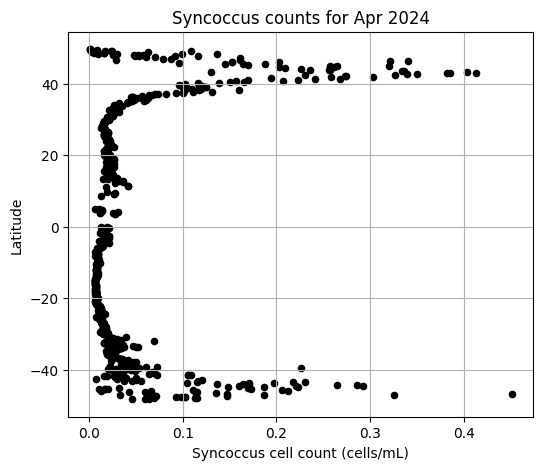

In [21]:
# Filter for a single date
target_date = "Apr 2024"
plot_df = final_df[final_df["month_year"] == target_date]

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(plot_df["syncoccus_moana"], plot_df["Lat"], c="k", s=20)
plt.xlabel("Syncoccus cell count (cells/mL)")  # update units if needed
plt.ylabel("Latitude")
plt.title(f"Syncoccus counts for {target_date}")
plt.grid(True)
plt.show()


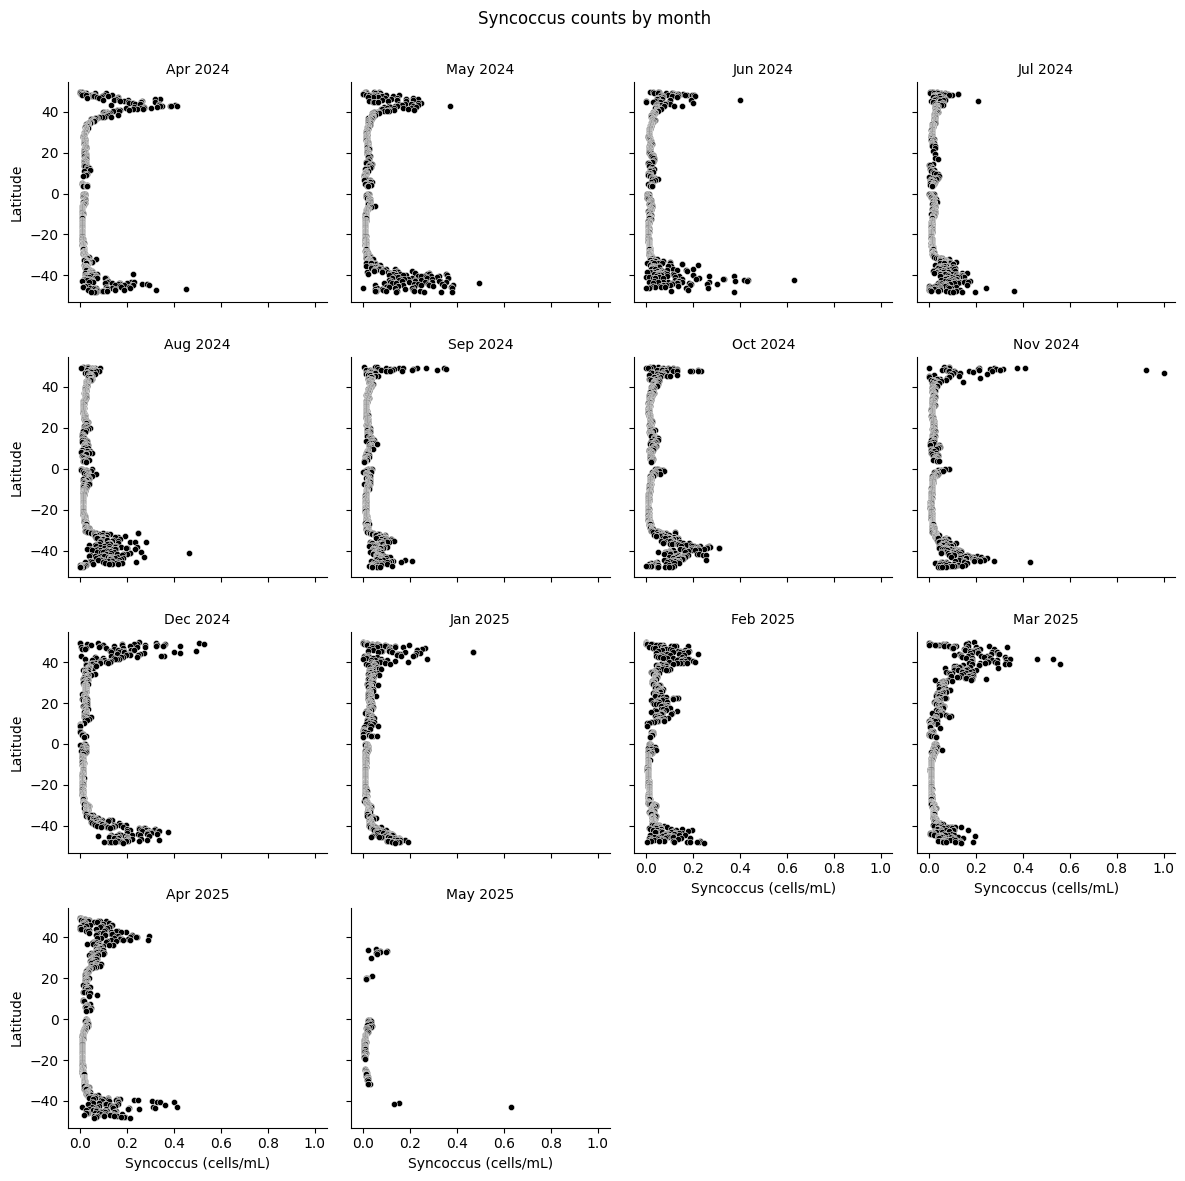

In [29]:
# Set up the facet grid
g = sns.FacetGrid(
    final_df, 
    col="month_year", 
    col_wrap=4, 
    height=3, 
    sharex=True, 
    sharey=True
)

# Plot cell count vs latitude in each panel
g.map_dataframe(
    sns.scatterplot, 
    x="syncoccus_moana", 
    y="Lat", 
    color="k", 
    s=20
)

# Label axes
g.set_axis_labels("Syncoccus (cells/mL)", "Latitude")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("MOANA Syncoccus counts by month")
plt.show()


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

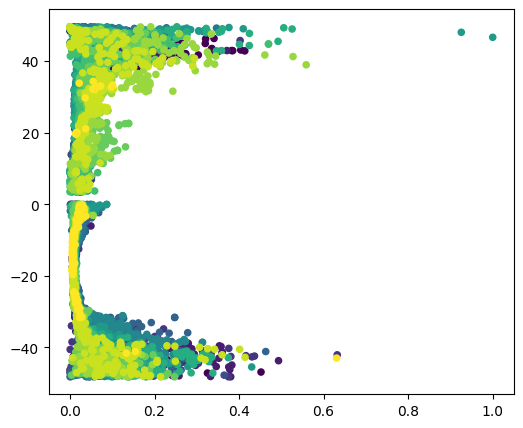

In [31]:
# Reorder by date to keep gradient smooth
df_sorted = final_df.sort_values("date")

# Convert to numeric time (for colormap)
from matplotlib import cm
from matplotlib.colors import Normalize

norm = Normalize(df_sorted["date"].min().value, df_sorted["date"].max().value)
colors = cm.viridis(norm(df_sorted["date"].values.astype("datetime64[ns]").astype("int64")))

plt.figure(figsize=(6, 5))
plt.scatter(
    df_sorted["syncoccus_moana"],
    df_sorted["Lat"],
    c=colors,
    s=20
)

# Colorbar with formatted ticks
sm = cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, label="Month")
cbar.ax.set_yticklabels(
    pd.to_datetime(cbar.get_ticks().astype("int64")).strftime("%b %Y"),
)

plt.xlabel("Syncoccus count")
plt.ylabel("Latitude")
plt.title("Syncoccus counts by latitude across months")
plt.grid(True)
plt.show()
